In [1]:
#Loading required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import chi2

<Figure size 720x540 with 0 Axes>

In [2]:
pwd

'C:\\Users\\PHANI KUMAR\\Desktop\\Python Machine Learning\\2. HR Analytics - Predicting employee Attrition'

In [3]:
# Load the data
hr_data = pd.read_csv( 'HR_comma_sep.csv' )

In [4]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
#Creating descriptives of the data
profile_sheet = pandas_profiling.ProfileReport(hr_data)
profile_sheet

In [6]:
profile_sheet.to_file('profile_report.html')

In [7]:
hr_data = pd.get_dummies(hr_data, ['department','salary'], drop_first=True)

In [8]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [9]:
#Missing vlaue treatment
def missings_treat(x):
    x = x.fillna(x.median())
    return x

#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

hr_data = hr_data.apply(lambda x: missings_treat(x))
hr_data = hr_data.apply(lambda x: outlier_capping(x))

# Variable Reduction

In [10]:
x = hr_data[hr_data.columns.difference(['left'])]
y = hr_data['left']

In [11]:
chi_scores = chi2(x,y)

In [12]:
p_values = pd.Series(chi_scores[1],index = x.columns)
p_values.sort_values(ascending = False,inplace = True)

In [13]:
p_values.round(5)

department_marketing      0.91861
last_evaluation           0.88039
department_sales          0.30110
department_support        0.22660
department_product_mng    0.19037
department_accounting     0.06976
number_project            0.06558
department_technical      0.02610
department_hr             0.00074
department_management     0.00000
department_RandD          0.00000
salary_medium             0.00000
promotion_last_5years     0.00000
salary_low                0.00000
time_spend_company        0.00000
satisfaction_level        0.00000
Work_accident             0.00000
average_montly_hours      0.00000
dtype: float64

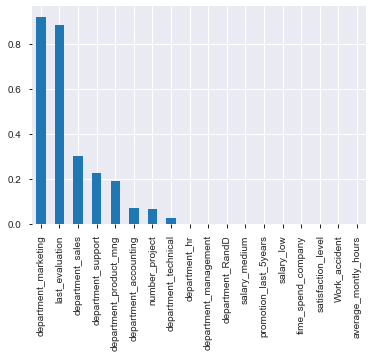

In [14]:
p_values.plot.bar()

In [15]:
#Based on chi square i selected following vars for evaluation
Final_vars = [#'department_technical','department_hr',
              #'department_management',
              #'department_RandD',
              'salary_medium','promotion_last_5years',
              'salary_low',
              'time_spend_company',
              'satisfaction_level',
              #'average_montly_hours'
              'Work_accident']

In [16]:
X_new = hr_data[Final_vars]

In [17]:
#RFE
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
a = X_new
b = hr_data[['left']]

rfe = RFE(RandomForestClassifier(), 8)
rfe = rfe.fit(a, b)

a.columns[rfe.get_support()]

Index(['salary_medium', 'promotion_last_5years', 'salary_low',
       'time_spend_company', 'satisfaction_level', 'Work_accident'],
      dtype='object')

In [18]:
### VIF Calculation for variables
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns

In [19]:
vif.sort_values(by='VIF_Factor',ascending=False)

,VIF_Factor,features
4,5.061323,satisfaction_level
3,4.855606,time_spend_company
2,3.863323,salary_low
0,3.658988,salary_medium
5,1.171765,Work_accident
1,1.037251,promotion_last_5years


In [20]:
#Final merged dataset after variable selection
data_final = pd.concat([X_new, b], axis=1)

In [21]:
data_final.head()

,salary_medium,promotion_last_5years,salary_low,time_spend_company,satisfaction_level,Work_accident,left
0,0,0,1,3,0.38,0,1
1,1,0,0,6,0.80,0,1
2,1,0,0,4,0.11,0,1
3,0,0,1,5,0.72,0,1
4,0,0,1,3,0.37,0,1


## Building Logistic model 

In [22]:
#split the data into train & test
train, test = train_test_split(data_final, test_size=0.3, random_state=999)

In [23]:
'left~'+'+'.join(train.columns.difference(['left']))

'left~Work_accident+promotion_last_5years+salary_low+salary_medium+satisfaction_level+time_spend_company'

In [24]:
formula = 'left~Work_accident+promotion_last_5years+salary_low+salary_medium+satisfaction_level+time_spend_company'

In [25]:
model = smf.logit(formula, data=train).fit()

Optimization terminated successfully.
         Current function value: 0.439643
         Iterations 7


In [26]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                10499
Model:                          Logit   Df Residuals:                    10492
Method:                           MLE   Df Model:                            6
Date:                Fri, 10 Jan 2020   Pseudo R-squ.:                  0.2040
Time:                        15:44:55   Log-Likelihood:                -4615.8
converged:                       True   LL-Null:                       -5798.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.4684      0.178     -8.235      0.000      -1.818      -1.119
Work_accident            -1.6344      0.109    -15.047      0.000      -1.847      -1.422
promotio

In [27]:
#Metrics based on the probability - AUC, Gini
train['prob'] = model.predict(train)
test['prob'] = model.predict(test)

In [28]:
train_auc = metrics.roc_auc_score(train.left, train.prob)
train_auc

0.8104102502463428

In [29]:
train_true = train['left']
train_probs = train['prob']

In [30]:
from sklearn.metrics import roc_curve,auc
import scikitplot as skplt

In [31]:
fpr,tpr,treshold = metrics.roc_curve(train_true,train_probs)

In [32]:
roc_auc = metrics.auc(fpr,tpr)

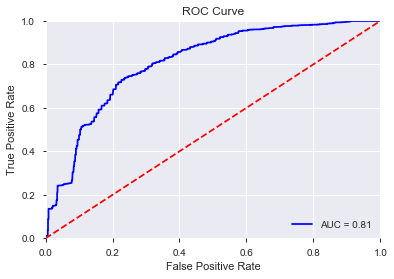

In [33]:
#Train AUC
plt.title('ROC Curve')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [34]:
test_true = test['left']
test_probs = test['prob']

In [35]:
test_auc = metrics.roc_auc_score(test.left, test.prob)
test_auc

0.8067916296131614

In [36]:
fpr_test,tpr_test,treshold_test = metrics.roc_curve(test_true,test_probs)
roc_auc_test = metrics.auc(fpr_test,tpr_test)

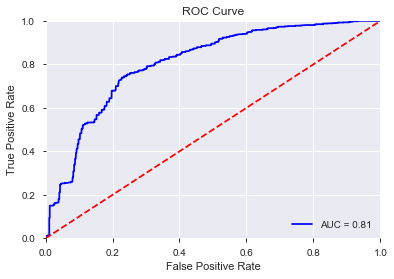

In [37]:
#Test AUC
plt.title('ROC Curve')
plt.plot(fpr_test,tpr_test,'b',label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [38]:
train_gini = 2*metrics.roc_auc_score(train.left, train.prob)-1
train_gini

0.6208205004926857

In [39]:
test_gini = 2*metrics.roc_auc_score(test.left, test.prob)-1
test_gini

0.6135832592263228

In [40]:
temp = train
roc_df = pd.DataFrame()
for cut_off in np.linspace(0,1):
    temp['y_pred'] = np.where(train.prob>cut_off, 1, 0)
    temp['TP'] = np.where(((train.left ==1) & (train.y_pred==1)), 1,0)
    temp['TN'] = np.where(((train.left ==0) & (train.y_pred==0)), 1,0)
    temp['FP'] = np.where(((train.left ==0) & (train.y_pred==1)), 1,0)
    temp['FN'] = np.where(((train.left ==1) & (train.y_pred==0)), 1,0)
    sensitivity = temp.TP.sum()/(temp.TP.sum()+temp.FN.sum())
    specificity = temp.TN.sum()/(temp.TN.sum()+temp.FP.sum())
    accuracy = (temp.TN.sum()+temp.TP.sum())/(temp.y_pred.count())
    temp_df = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    temp_df.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_df = pd.concat([roc_df, temp_df], axis=0)

In [41]:
roc_df['total'] = roc_df.sensitivity + roc_df.specificity

In [42]:
roc_df.sort_values(by = 'total', ascending=False).head()

,cutoff,sensitivity,specificity,accuracy,total
0,0.265306,0.727776,0.773092,0.762168,1.500868
0,0.244898,0.751087,0.740713,0.743214,1.491799
0,0.285714,0.685895,0.795055,0.768740,1.480950
0,0.224490,0.777163,0.701180,0.719497,1.478343
0,0.204082,0.810352,0.664408,0.699590,1.474759


In [43]:
roc_df[roc_df.total == roc_df.total.max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.265306,0.727776,0.773092,0.762168,1.500868


In [44]:
#From above step, the cut-off is: 0.265306
train['default_pred'] = np.where(train.prob>0.265306, 1, 0)
test['default_pred'] = np.where(test.prob>0.265306, 1, 0)

In [45]:
metrics.confusion_matrix(train.left, train.default_pred)

array([[6160, 1808],
       [ 689, 1842]], dtype=int64)

In [46]:
#Good ness of fit metrics based on categorical predicted output for train & test

print(metrics.classification_report(train.left, train.default_pred))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      7968
           1       0.50      0.73      0.60      2531

    accuracy                           0.76     10499
   macro avg       0.70      0.75      0.71     10499
weighted avg       0.80      0.76      0.77     10499



In [47]:
print(metrics.classification_report(test.left, test.default_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      3460
           1       0.49      0.74      0.59      1040

    accuracy                           0.76      4500
   macro avg       0.70      0.75      0.71      4500
weighted avg       0.81      0.76      0.77      4500



In [48]:
#Decile Analysis
train['Deciles']=pd.qcut(train['prob'],10, labels=False)
test['Deciles']=pd.qcut(test['prob'],10, labels=False)

In [50]:
train['goods'] = 1-train.left
test['goods'] = 1-test.left

In [101]:
#Decile Analysis for train
a = train.groupby('Deciles').agg({'prob' : ['min','max']})
b = train.groupby('Deciles').agg({'left' : ['sum','count']})
c = train.groupby('Deciles').agg({'goods' : ['sum']})
#Data frame conversion
a = pd.DataFrame(a)
b = pd.DataFrame(b)
c = pd.DataFrame(c)

In [102]:
#Concatenate dataframes
decile_results_train = pd.concat([a,b,c],axis = 1)
decile_results_train.columns = ['min_prob','max_prob','No_bads','total','No_goods']
decile_results_train = decile_results_train[['min_prob','max_prob','No_bads','No_goods','total']]

In [103]:
decile_results_train

,min_prob,max_prob,No_bads,No_goods,total
Deciles,,,,,
0,0.001239,0.035088,18,1040,1058
1,0.035229,0.068549,37,1009,1046
2,0.068646,0.100889,47,1002,1049
3,0.101166,0.137645,136,917,1053
4,0.137825,0.180716,153,914,1067
5,0.181194,0.231962,199,827,1026
6,0.231966,0.296392,331,729,1060
7,0.297262,0.406862,344,702,1046
8,0.407729,0.575110,644,407,1051


In [104]:
#Decile analysis for test
d = test.groupby('Deciles').agg({'prob' : ['min','max']})
e = test.groupby('Deciles').agg({'left' : ['sum','count']})
f = test.groupby('Deciles').agg({'goods' : ['sum']})
#Data frame conversion
d = pd.DataFrame(d)
e = pd.DataFrame(e)
f = pd.DataFrame(f)

In [105]:
#Concatenate dataframes
decile_results_test = pd.concat([d,e,f],axis = 1)
decile_results_test.columns = ['min_prob','max_prob','No_bads','total','No_goods']
decile_results_test = decile_results_test[['min_prob','max_prob','No_bads','No_goods','total']]

In [106]:
decile_results_test

,min_prob,max_prob,No_bads,No_goods,total
Deciles,,,,,
0,0.001435,0.037974,9,443,452
1,0.038195,0.069583,14,434,448
2,0.069595,0.102721,22,428,450
3,0.102772,0.138569,57,394,451
4,0.138816,0.182486,60,389,449
5,0.182712,0.233613,75,377,452
6,0.234295,0.298129,133,317,450
7,0.299873,0.406862,146,304,450
8,0.407729,0.593155,261,187,448


In [107]:
#Exporting to csv
decile_results_train.to_csv('decile_results_train.csv')
decile_results_test.to_csv('decile_results_test.csv')

In [114]:
hr_data['prob']  = model.predict(hr_data)

In [115]:
#Cutoff value = 0.265306
hr_data['left_predict'] = np.where(hr_data.prob > 0.265306,1,0)

In [116]:
hr_data.left_predict.value_counts()

0    9762
1    5237
Name: left_predict, dtype: int64

In [117]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,...,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,prob,left_predict
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0.472387,1
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0.184897,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0.636638,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0.296392,1
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0.481584,1
